In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-01_08-59_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.1813562634356068

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

GC       0.25
ES       0.25
YM       0.25
NQ       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     5586.30
GC     6053.96
NQ    30869.00
YM    35648.80
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

78158.06

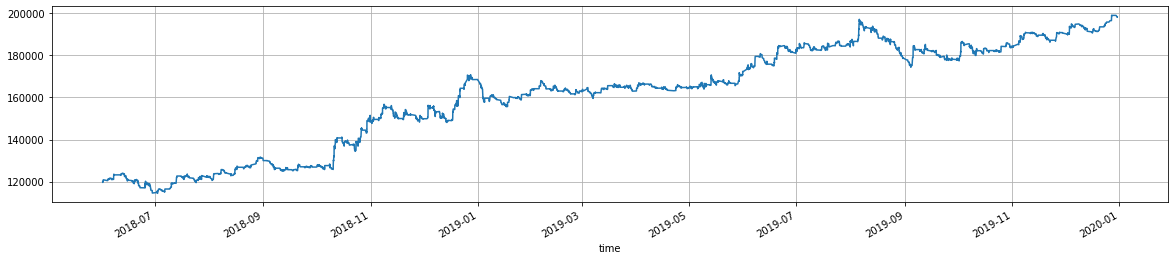

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     823
 GC    1362
 NQ    2210
 YM     722
 Name: action, dtype: int64,
 5117)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.997573
 GC    3.305825
 NQ    5.364078
 YM    1.752427
 Name: action, dtype: float64,
 12.419902912621358)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1728.30
GC    3296.04
NQ    4641.00
YM    1516.20
Name: commission, dtype: float64

In [16]:
df.commission.sum()

11181.54

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.41,8.89,397.73,-256.10,1.55,11.97,681.0
NQ,0.40,27.94,449.32,-252.99,1.78,27.93,1105.0
YM,0.43,98.75,712.36,-373.49,1.91,93.43,361.0
ES,0.40,13.59,773.25,-485.70,1.59,17.88,411.0
total,0.41,30.55,526.26,-307.96,1.71,34.07,2558.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.079408,0.211207,0.417875,0.743136
GC,0.079408,1.000000,0.073284,0.105907,0.418032
NQ,0.211207,0.073284,1.000000,0.146889,0.611693
YM,0.417875,0.105907,0.146889,1.000000,0.674486
total,0.743136,0.418032,0.611693,0.674486,1.000000


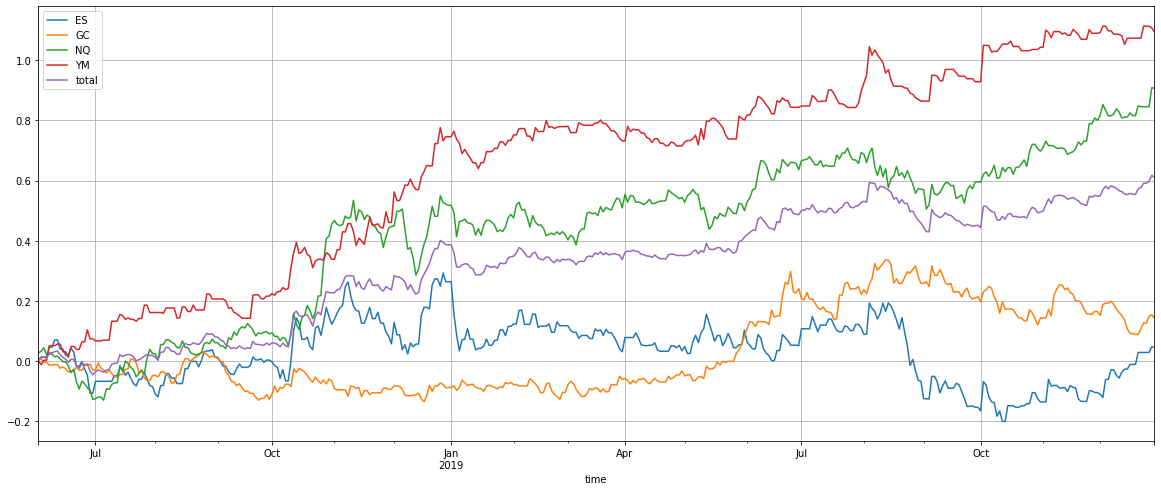

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

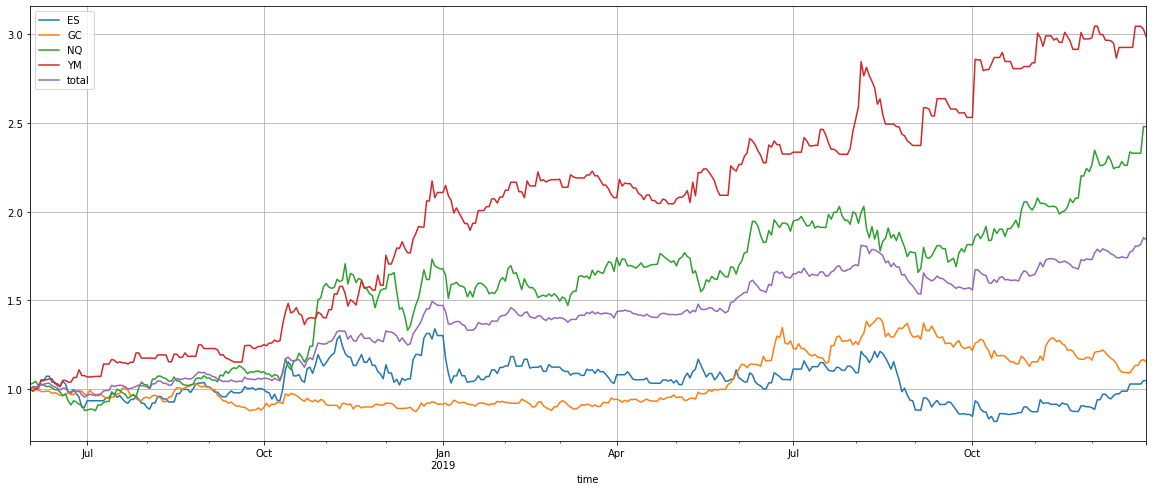

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.028863,0.090504,0.742430,0.952636,0.452880
Cumulative returns,0.047620,0.152172,1.478961,1.986364,0.841759
Annual volatility,0.416518,0.272849,0.385346,0.342211,0.223640
Sharpe ratio,0.273447,0.452375,1.633255,2.123894,1.781338
Calmar ratio,0.074063,0.411605,3.376300,5.736553,2.989168
Stability,0.046216,0.543478,0.849130,0.922741,0.907389
Max drawdown,-0.389708,-0.219880,-0.219894,-0.166064,-0.151507
Omega ratio,1.053597,1.085670,1.333728,1.605183,1.406874
Sortino ratio,0.437293,0.736158,2.692921,4.669579,3.469077
Skew,0.797768,0.872349,0.416722,1.923613,1.604673


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-10.22,-3.04,-11.98,7.59,-4.51
2018-07-31,2.27,-1.78,16.47,9.18,6.62
2018-08-31,10.23,6.42,3.66,4.60,6.41
2018-09-30,-0.93,-13.10,2.94,0.97,-2.59
2018-10-31,12.65,6.23,44.14,13.00,18.83
2018-11-30,-6.32,-2.78,-0.77,13.08,1.02
2018-12-31,22.98,0.62,7.25,32.99,16.13
2019-01-31,-13.79,1.71,-2.96,-1.22,-3.87
2019-02-28,0.20,-3.25,-6.53,4.71,-1.06


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES         5.0
GC        15.0
NQ       148.0
YM       199.0
total     84.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:00,YM,BUY,26061.00,3885.80
2018-10-11 04:24:00,ES,BUY,2767.00,3395.80
2018-12-03 15:47:00,YM,SELL,25944.00,3205.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-12-17 16:30:00,ES,BUY,2585.75,3045.80
...,...,...,...,...
2018-12-06 20:00:00,ES,BUY,2671.50,-1316.70
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20
2018-12-07 15:39:30,ES,BUY,2701.25,-1379.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-09-05,0.078193,0.071505,0.070387,0.089720,0.077451
2019-10-02,0.102913,0.034355,0.026633,0.129527,0.073357
2018-10-11,0.107773,0.060355,0.068633,0.050107,0.071717
2019-08-05,0.109163,0.031849,0.031320,0.098887,0.067805
2018-12-03,0.074443,0.012677,0.001080,0.106860,0.048765
...,...,...,...,...,...
2019-01-02,-0.101113,0.005839,-0.021920,0.018720,-0.024619
2019-10-09,-0.044030,-0.015656,-0.041893,0.000000,-0.025395
2019-08-26,-0.063613,-0.003817,-0.023280,-0.016307,-0.026754
